<center>
    
# SWEET LIFT TAXI

# Descrição do Projeto

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 	
Construiremos modelos para tal predição e escolheremos o melhor modelo com base no REQM obtido e no tempo de treinamento.

## Preparação 

In [2]:
import pandas as pd
import numpy as np

import time
import timeit

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import root_mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Lendo o arquivo e definindo a primeira coluna como índice
data = pd.read_csv('./datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Reamostrando os dados para 1 hora
data = data.resample('1h').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Análise

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


O DataFrame tem somente uma coluna 'num_orders' e não apresenta dados nulos. Portanto não precisamos ajustá-lo neste sentido.

In [6]:
# Verificando se as datas nos índices apresentam crescimento monotônico.
data.index.is_monotonic_increasing

True

Os dados estão em ordem cronológica, conforme nossa necessidade.

In [7]:
# Verificando se os dados de 'num_orders' apresentam crescimento monotônico.
data.num_orders.is_monotonic_increasing

False

<Axes: xlabel='datetime'>

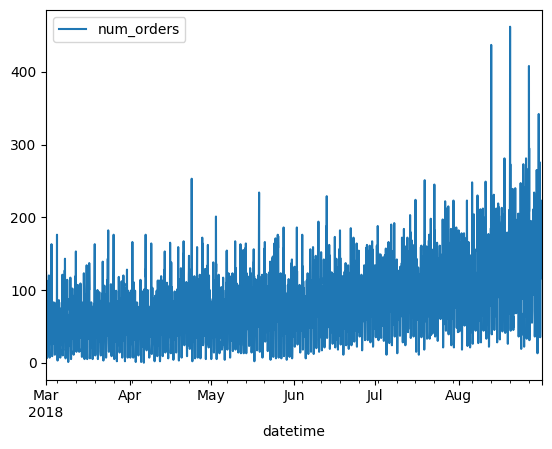

In [8]:
# Plotando os dados 
data.plot()

### Decomposição

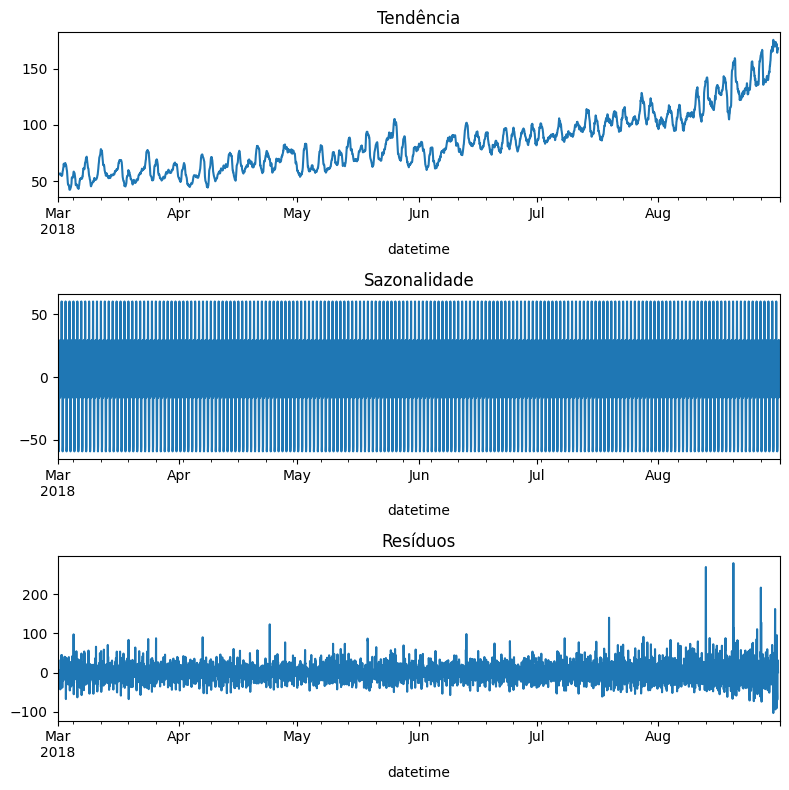

In [9]:
# Fazendo a decomposição dos dados em tendência, sazonalidade e resíduo
decompose = seasonal_decompose(data)

# Plotando tendência
plt.figure(figsize=(8,8))
plt.subplot(311)
decompose.trend.plot(ax=plt.gca())
plt.title('Tendência')

# Plotando sazonalidade
plt.subplot(312)
decompose.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

# Plotando resíduo
plt.subplot(313)
decompose.resid.plot(ax=plt.gca())
plt.title('Resíduos')

plt.tight_layout()

**Tendência:** Os dados apresentam uma tendência de alta em relação aos pedidos de táxi de abril até agosto;  

**Sazonalidade:** A densidade das linhas indica que há padrões que se repetem com frequência, sugerindo ciclos diários de demanda. As oscilações mostram as flutuações de hora em hora. Esse comportamento sugere variações significativas dentro de cada dia, reforçando a ideia de horários de pico e vales de demanda. A alta densidade de linhas pode indicar que, em algumas horas, a demanda muda rapidamente.

**Resíduos:** O gráfico mostrou que há bastante variabilidade, com alguns picos. Isso indica que existem variabilidades nos dados que são imprevisíveis e não seguem um padrão fixo. Isso pode estar relacionado a vários fatores, como horários de chuva, eventos, entre outros que não temos dados suficientes para explorar.

### Diferenças de séries temporais

In [10]:
# Criando coluna com a diferença das séries temporais
data_shift = data['num_orders'].shift(fill_value=0)
data['diff'] = data['num_orders'] - data_shift

data.head()

,num_orders,diff
datetime,,
2018-03-01 00:00:00,124,124
2018-03-01 01:00:00,85,-39
2018-03-01 02:00:00,71,-14
2018-03-01 03:00:00,66,-5
2018-03-01 04:00:00,43,-23


#### Decomposição da diferença das séries temporais

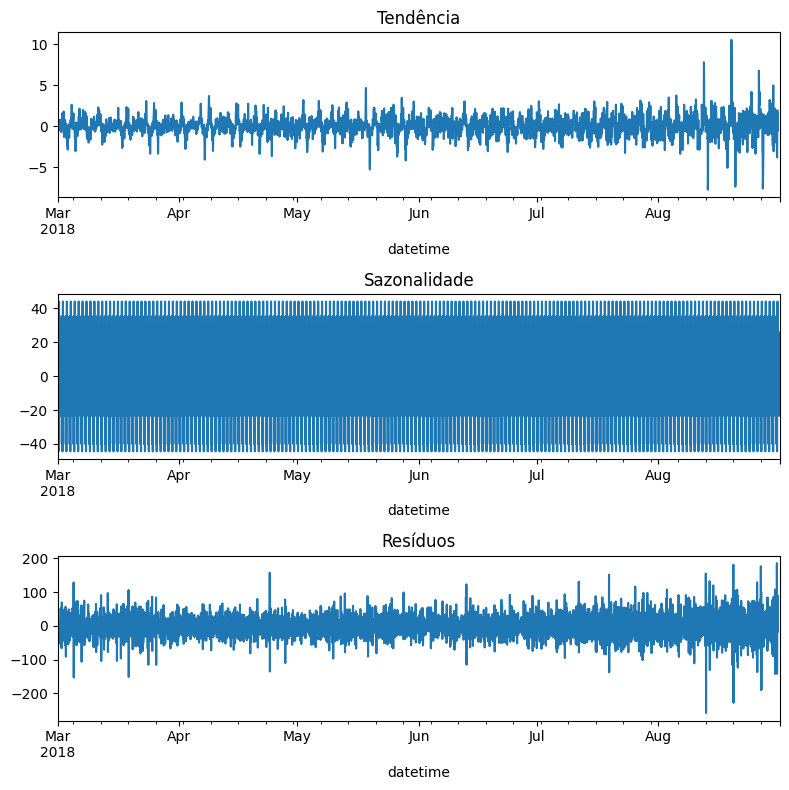

In [11]:
decompose = seasonal_decompose(data['diff'])

plt.figure(figsize=(8,8))
plt.subplot(311)
decompose.trend.plot(ax=plt.gca())
plt.title('Tendência')

plt.subplot(312)
decompose.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

plt.subplot(313)
decompose.resid.plot(ax=plt.gca())
plt.title('Resíduos')

plt.tight_layout()

### Criando características

In [12]:
def make_features(data, max_lag, rolling_mean_size):

    data['day_of_week'] = data.index.dayofweek
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['hour'] = data.index.hour
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    return data

In [13]:
# Chamando a função para criar as colunas de características
# Escolhi 24 devido ao dia ter 24 horas
make_features(data, 24, 24)
data.head()

,num_orders,diff,day_of_week,day,month,hour,rolling_mean,lag_1,lag_2,lag_3,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,124,3,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,-39,3,1,3,1,NaN,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,-14,3,1,3,2,NaN,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,-5,3,1,3,3,NaN,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,-23,3,1,3,4,NaN,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Divisão dos dados em conjuntos de treino, validação e teste

In [14]:
# Na primeira etapa, dividiremos os dados em 80% para conjunto de "treinamento" e 20% para "conjunto de dados restantes"
train, remain = train_test_split(data, shuffle=False, test_size=0.2)

# Como queremos 10% dos dados iniciais para teste, vamos definir test_size que represente 50% dos dados restantes
valid, test = train_test_split(remain, shuffle=False, test_size=0.5)


train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(3508, 30)
(3508,)
(442, 30)
(442,)
(442, 30)
(442,)


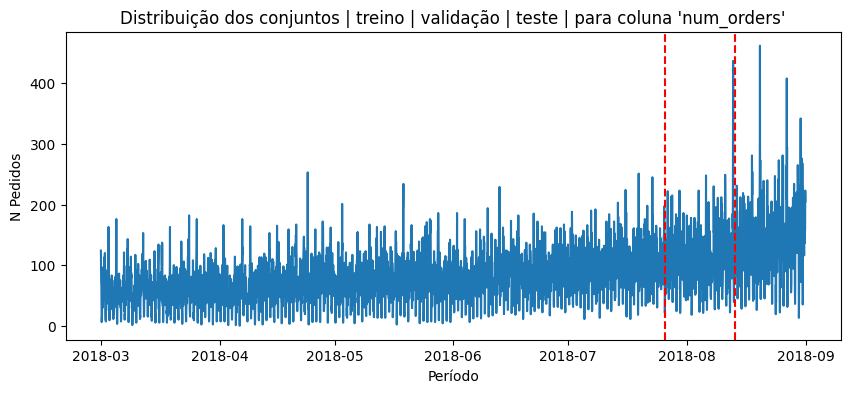

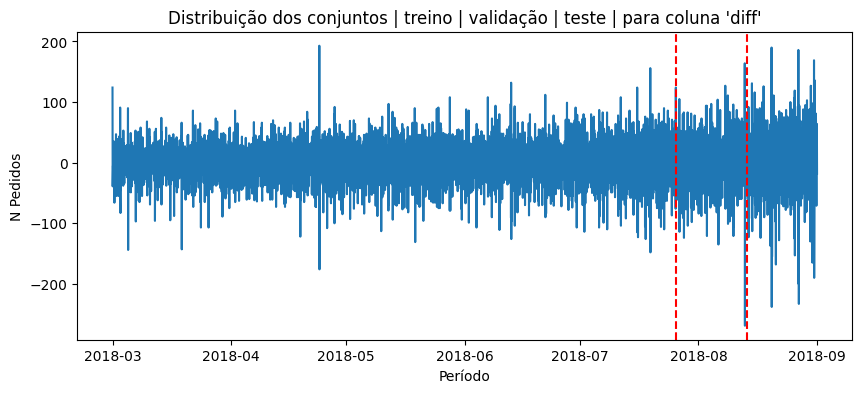

In [15]:
# Criando gráfico para inspeção visual da distribuição e comportamento dos dados
position_train = int(0.8 * len(data))
vertical_line_position_train = data.index[position_train]

position_valid = int(0.9 * len(data))
vertical_line_position_valid = data.index[position_valid]


# Coluna num_orders
plt.figure(figsize=(10, 4))
plt.plot(data.index, data['num_orders'])

# Adicionando as linhas verticais
plt.axvline(x=vertical_line_position_train, color='r', linestyle='--')
plt.axvline(x=vertical_line_position_valid, color='r', linestyle='--')

# Adicionando título e rótulos dos eixos
plt.title("Distribuição dos conjuntos | treino | validação | teste | para coluna 'num_orders'")
plt.xlabel('Período')
plt.ylabel('N Pedidos')



# Coluna 'diff'
plt.figure(figsize=(10, 4))
plt.plot(data.index, data['diff'])

# Adicionando as linhas verticais
plt.axvline(x=vertical_line_position_train, color='r', linestyle='--')
plt.axvline(x=vertical_line_position_valid, color='r', linestyle='--')

# Adicionando título e rótulos dos eixos
plt.title("Distribuição dos conjuntos | treino | validação | teste | para coluna 'diff'")
plt.xlabel('Período')
plt.ylabel('N Pedidos')

plt.show()

## Treinamento e teste dos modelos

### Regressão Linear

In [16]:
model_reg = LinearRegression()

# Medindo o tempo de treinamento do modelo
time_train_reg = timeit.timeit(lambda: model_reg.fit(features_train, target_train), number=1)

model_reg.fit(features_train, target_train)

predict_valid_reg = model_reg.predict(features_valid)
reqm_valid_reg = root_mean_squared_error(predict_valid_reg, target_valid)

predict_test_reg = model_reg.predict(features_test)
reqm_test_reg = root_mean_squared_error(predict_test_reg, target_test)

print(f'Tempo de execução: {time_train_reg} segundos')
print('REQM para conjunto de validação:', reqm_valid_reg)
print()
print('REQM para conjunto de teste:', reqm_test_reg)

Tempo de execução: 0.10393829992972314 segundos
REQM para conjunto de validação: 8.215104553092869e-14

REQM para conjunto de teste: 1.2711147744212784e-13


### Floresta Aleatória

In [17]:
# Definindo o modelo de Floresta Aleatória
model_forest = RandomForestRegressor(random_state=12345)

# Definindo a grade de hiperparâmetros
param_grid = {'n_estimators': [1, 5, 10, 50],
              'max_depth': [None, 2, 5, 10, 20, 30],
              'min_samples_split': [2, 5, 10, 20]}

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=model_forest, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')


# Função para executar o ajuste do modelo
def fit_model_forest():
    grid_search.fit(features_train, target_train)

# Medindo o tempo de execução do treinamento
time_train_forest = timeit.timeit(fit_model_forest, number=1)

# Treinando o modelo e fazendo as predições
grid_search.fit(features_train, target_train)
best_model_forest = grid_search.best_estimator_


predict_valid_forest = best_model_forest.predict(features_valid)
predict_test_forest = best_model_forest.predict(features_test)


# Avaliando o modelo
reqm_valid_forest = root_mean_squared_error(target_valid, predict_valid_forest)
reqm_test_forest = root_mean_squared_error(target_test, predict_test_forest)
print('Melhores Hiperparâmetros:', grid_search.best_params_)
print(f'Tempo de execução: {time_train_forest} segundos')
print()
print('REQM para conjunto de validação:', reqm_valid_forest)
print()
print('REQM para conjunto de teste:', reqm_test_forest)

Melhores Hiperparâmetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
Tempo de execução: 95.46971569978632 segundos

REQM para conjunto de validação: 14.917263223575832

REQM para conjunto de teste: 29.208791012265294


### CatBoost

In [27]:
# Definindo o modelo de CatBoost
model_cat = CatBoostRegressor(random_seed=12345, loss_function='RMSE', early_stopping_rounds=10)
model_cat.fit(features_train, target_train)

# Definindo a grade de hiperparâmetros
param_grid = {'learning_rate': [0.1, 0.2, 0.3],
              'depth': [1, 3, 6, 10],
              'iterations': [50, 100, 150]}
    

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=model_cat, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')


# Função para executar o ajuste do modelo
def fit_model_cat():
    grid_search.fit(features_train, target_train, eval_set=(features_valid, target_valid), verbose=10, use_best_model=True)

# Medindo o tempo de execução do treinamento
time_train_cat = timeit.timeit(fit_model_cat, number=1)

# Treinando o modelo e fazendo as predições
grid_search.fit(features_train, target_train, eval_set=(features_valid, target_valid), verbose=10, use_best_model=True)
best_model_cat = grid_search.best_estimator_


predict_valid_cat = best_model_cat.predict(features_valid)
predict_test_cat = best_model_cat.predict(features_test)

# Avaliando o modelo
reqm_valid_cat = root_mean_squared_error(target_valid, predict_valid_cat)
reqm_test_cat = root_mean_squared_error(target_test, predict_test_cat)

print('Melhores Hiperparâmetros:', grid_search.best_params_)
print(f'Tempo de execução: {time_train_cat} segundos')
print()
print('REQM para conjunto de validação:', reqm_valid_cat)
print()
print('REQM para conjunto de teste:', reqm_test_cat)

Learning rate set to 0.049923
0:	learn: 34.6137281	total: 18.8ms	remaining: 18.8s
1:	learn: 33.4929033	total: 30.4ms	remaining: 15.2s
2:	learn: 32.3481372	total: 77.9ms	remaining: 25.9s
3:	learn: 31.2097924	total: 109ms	remaining: 27.2s
4:	learn: 30.3229327	total: 172ms	remaining: 34.2s
5:	learn: 29.3582961	total: 260ms	remaining: 43.1s
6:	learn: 28.4006837	total: 290ms	remaining: 41.1s
7:	learn: 27.5304065	total: 318ms	remaining: 39.5s
8:	learn: 26.7037320	total: 340ms	remaining: 37.5s
9:	learn: 25.8850924	total: 352ms	remaining: 34.9s
10:	learn: 25.1884077	total: 383ms	remaining: 34.5s
11:	learn: 24.4545866	total: 411ms	remaining: 33.9s
12:	learn: 23.6817513	total: 421ms	remaining: 32s
13:	learn: 22.9331275	total: 431ms	remaining: 30.3s
14:	learn: 22.2033585	total: 440ms	remaining: 28.9s
15:	learn: 21.5290459	total: 451ms	remaining: 27.7s
16:	learn: 20.9248781	total: 460ms	remaining: 26.6s
17:	learn: 20.3660707	total: 470ms	remaining: 25.6s
18:	learn: 19.7477827	total: 481ms	remainin

### LGBM

In [19]:
# Definindo o modelo LGBM
model_lgb = lgb.LGBMRegressor(random_state=12345)

# Definindo a grade de hiperparâmetros
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [10, 30, 50],
    'n_estimators': [50, 100, 150],
    'max_depth': [-1, 5, 10]}

# Configurando o GridSearchCV
grid_search = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error')

# Função callback para logging
callbacks = [lgb.log_evaluation(period=10), lgb.early_stopping(stopping_rounds=10)]

# Função para ajustar o modelo
def fit_model():
    grid_search.fit(
        features_train, target_train,
        eval_set=[(features_valid, target_valid)],
        eval_metric='rmse',
        callbacks=callbacks)

# Medindo o tempo de execução
time_train_lgb = timeit.timeit(fit_model, number=1)

# Treinando o modelo
fit_model()
best_model_lgb = grid_search.best_estimator_

# Fazendo as predições e avaliando o modelo
predict_valid_lgb = best_model_lgb.predict(features_valid)
predict_test_lgb = best_model_lgb.predict(features_test)

reqm_valid_lgb = root_mean_squared_error(target_valid, predict_valid_lgb)
reqm_test_lgb = root_mean_squared_error(target_test, predict_test_lgb)

print(f'Tempo de execução: {time_train_lgb} segundos')
print('Melhores Hiperparâmetros:', grid_search.best_params_)
print()
print('REQM para conjunto de validação:', reqm_valid_lgb)
print()
print('REQM para conjunto de teste:', reqm_test_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4724
[LightGBM] [Info] Number of data points in the train set: 3508, number of used features: 30
[LightGBM] [Info] Start training from score 74.427024
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 35.5006	valid_0's l2: 1260.29
[20]	valid_0's rmse: 24.8294	valid_0's l2: 616.501
[30]	valid_0's rmse: 19.4858	valid_0's l2: 379.695
[40]	valid_0's rmse: 16.6096	valid_0's l2: 275.88
[50]	valid_0's rmse: 15.2171	valid_0's l2: 231.56
[60]	valid_0's rmse: 14.3112	valid_0's l2: 204.81
[70]	valid_0's rmse: 13.7364	valid_0's l2: 188.69
[80]	valid_0's rmse: 13.4168	valid_0's l2: 180.011
[90]	valid_0's rmse: 13.1626	valid_0's l2: 173.254
[100]	valid_0's rmse: 13.0051	valid_0's l2: 169.132
[110]	valid_0's rmse: 12.9035	valid_0's l2: 166.501
[LightGBM] [Warning] No further splits

### XGBoost

In [28]:
# Definindo o modelo XGBoost
model_xgb = xgb.XGBRegressor(random_state=12345, eval_metric='rmse', early_stopping_rounds=10)

# Definindo a grade de hiperparâmetros
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 150],
    'colsample_bytree': [0.3, 0.7]}

# Configurando o GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error')

# Função para ajustar o modelo
def fit_model_xgb():
    grid_search_xgb.fit(
        features_train, target_train,
        eval_set=[(features_valid, target_valid)],
        verbose=10)

# Medindo o tempo de execução
time_train_xgb = timeit.timeit(fit_model_xgb, number=1)

# Treinando o modelo
fit_model_xgb()
best_model_xgb = grid_search_xgb.best_estimator_

# Fazendo as predições e avaliando o modelo
predict_valid_xgb = best_model_xgb.predict(features_valid)
predict_test_xgb = best_model_xgb.predict(features_test)

reqm_valid_xgb = root_mean_squared_error(target_valid, predict_valid_xgb)
reqm_test_xgb = root_mean_squared_error(target_test, predict_test_xgb)

print(f'Tempo de execução: {time_train_xgb} segundos')
print('Melhores Hiperparâmetros:', grid_search_xgb.best_params_)
print()
print('REQM para conjunto de validação:', reqm_valid_xgb)
print()
print('REQM para conjunto de teste:', reqm_test_xgb)

[0]	validation_0-rmse:54.65676
[10]	validation_0-rmse:27.96597
[20]	validation_0-rmse:19.62484
[30]	validation_0-rmse:16.24939
[40]	validation_0-rmse:13.34201
[50]	validation_0-rmse:12.30864
[60]	validation_0-rmse:11.65455
[70]	validation_0-rmse:11.40706
[80]	validation_0-rmse:11.17524
[90]	validation_0-rmse:10.76345
[100]	validation_0-rmse:10.40312
[110]	validation_0-rmse:10.26834
[120]	validation_0-rmse:10.16367
[130]	validation_0-rmse:10.08338
[140]	validation_0-rmse:10.00523
[149]	validation_0-rmse:9.94274
[0]	validation_0-rmse:54.65676
[10]	validation_0-rmse:27.96597
[20]	validation_0-rmse:19.62484
[30]	validation_0-rmse:16.24939
[40]	validation_0-rmse:13.34201
[50]	validation_0-rmse:12.30864
[60]	validation_0-rmse:11.65455
[70]	validation_0-rmse:11.40706
[80]	validation_0-rmse:11.17524
[90]	validation_0-rmse:10.76345
[100]	validation_0-rmse:10.40312
[110]	validation_0-rmse:10.26834
[120]	validation_0-rmse:10.16367
[130]	validation_0-rmse:10.08338
[140]	validation_0-rmse:10.00523


## Resultados

In [29]:
results = {
    'model': ['Regressão Linear', 'Floresta Aleatória', 'CatBoost', 'LightGBM', 'XGBoost'],
    'REQM_valid': [reqm_valid_reg, reqm_valid_forest, reqm_valid_cat, reqm_valid_lgb, reqm_valid_xgb],
    'REQM_test': [reqm_test_reg, reqm_test_forest, reqm_test_cat, reqm_test_lgb, reqm_test_xgb],
    'time_train_(s)': [time_train_reg, time_train_forest, time_train_cat, time_train_lgb, time_train_xgb]}

df_results = pd.DataFrame(results)
df_results = df_results.set_index('model')
df_results

,REQM_valid,REQM_test,time_train_(s)
model,,,
Regressão Linear,8.215105e-14,1.271115e-13,0.103938
Floresta Aleatória,1.491726e+01,2.920879e+01,95.469716
CatBoost,9.826742e+00,1.837082e+01,278.866832
LightGBM,1.278076e+01,2.465510e+01,42.056375
XGBoost,9.936589e+00,2.183817e+01,103.228728


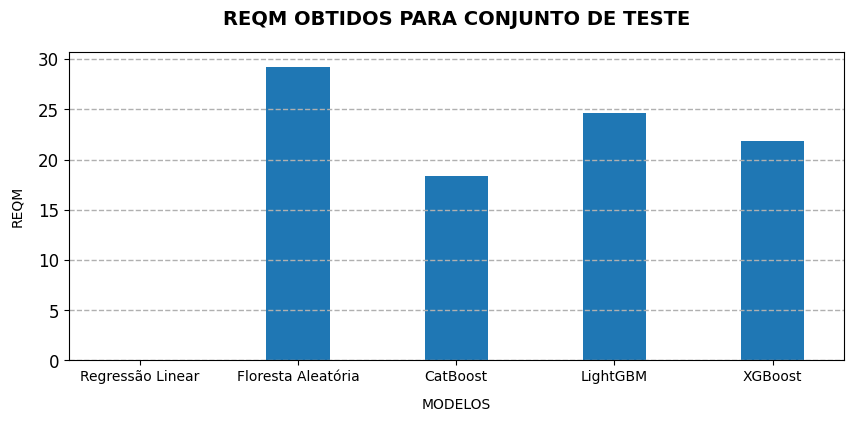

In [31]:
# Plotando um gráfico de barras para visualização dos resultados de REQM
ax = df_results['REQM_test'].plot(kind='bar',
                    figsize=[10, 4],
                    width=0.4)

# Ajustando o título e os rótulos dos eixos
ax.set_title('REQM OBTIDOS PARA CONJUNTO DE TESTE', fontsize=14, weight='bold', pad=20)
ax.set_xlabel('MODELOS', fontsize=10, labelpad=10)
ax.set_ylabel('REQM', fontsize=10, labelpad=10)

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(df_results.index, rotation=0)

# Ajustando o tamanho dos rótulos dos eixos
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Adicionando gridlines
ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')

# Exibindo o gráfico
plt.show()

**Regressão Linear:** Apresentou valores extremamente baixos de REQM quando utilizadas as colunas 'num_orders' e 'diff'. Este valor de REQM indica que há um problema com o modelo, sendo possível que esteja sofrendo de overfitting, ou que a combinação de dados originais e diferenças de séries temporais pode ter impactado o modelo. Portanto, Esses resultados não serão considerados como confiáveis.

Desta forma, **o melhor resultado de REQM obtido foi o do modelo CatBoost**

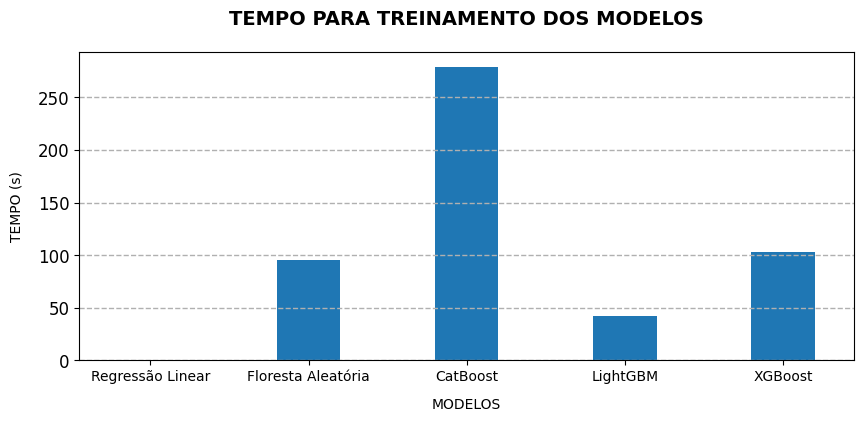

In [32]:
# Plotando um gráfico de barras para visualização dos tempos de treinamento dos modelos
ax = df_results['time_train_(s)'].plot(kind='bar',
                    figsize=[10, 4],
                    width=0.4)

# Ajustando o título e os rótulos dos eixos
ax.set_title('TEMPO PARA TREINAMENTO DOS MODELOS', fontsize=14, weight='bold', pad=20)
ax.set_xlabel('MODELOS', fontsize=10, labelpad=10)
ax.set_ylabel('TEMPO (s)', fontsize=10, labelpad=10)

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(df_results.index, rotation=0)

# Ajustando o tamanho dos rótulos dos eixos
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Adicionando gridlines
ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')

# Exibindo o gráfico
plt.show()

O tempo gasto para o treinamento do modelo CatBoost foi praticamente o dobro do tempo gasto para os treinamentos dos modelos de Floresta e LGBM. porém, como o REQM deste modelo foi melhor do que os outros 2 modelos, ele foi considerado o melhor modelo

## Outros testes realizados com diferentes parâmetros

In [24]:
# Foram realizados todos os testes de treinamento dos modelos abaixo, onde:

    # num_orders - treinamento dos modelos usando apenas a coluna num_orders com os dados originais,
    # diff       - treinamento dos modelos usando apenas a coluna diff com dados das diferenças de séries temporais,
    # diff_24    - treinamento dos modelos usando a coluna diff + características + lag=24 + rolling_mean=24,
    # diff_100   - treinamento dos modelos usando a coluna diff + características + lag=100 + rolling_mean=100,
    # both_100   - treinamento dos modelos usando colunas diff + num_orders + características + lag=100 + rolling_mean=100,
    # both_24    - treinamento dos modelos usando coluna diff + num_orders + características + lag=24 + rolling_mean=24


tests = ['num_orders', 'diff', 'diff_24', 'diff_100', 'both_100', 'both_24']


# Resultados de REQM nos conjuntos de teste em todos os testes realizados
reqm_results = {
    'Regressão' : [46.48, 45.32, 45.32, 39.96, 1.75e-13, 1.68e-13],
    'Floresta' : [49.42, 47.77, 47.15, 47.76, 29.56, 29.21],
    'CatBoost' : [48.06, 45.49, 44.02, 44.80, 18.34, 18.37],
    'LGBM' : [51.27, 45.93, 44.62, 45.38, 24.27, 25.17],
    'XGBoost' : [53.23, 45.40, 44.08, 44.46, 22.70, 20.71]}


# Resultados de tempo de treinamento nos testes realizados
time_train_results = {
    'Regressão': [0.007, 0.018, 0.007, 0.071, 0.024, 0.008],
    'Floresta': [143.7, 341.5, 144.4, 511.2, 443.5, 131.3],
    'CatBoost': [179.8, 226.2, 216.8, 814.2, 856.7, 250.5],
    'LGBM': [120.7, 121.5, 127.9, 315.4, 318.5, 118.2],
    'XGBoost': [303.2, 332.2, 337.9, 607.6, 659.1, 361.2]}


# DataFrame para REQM
df_reqm = pd.DataFrame(data=reqm_results, index=tests)

# DataFrame para tempo de treinamento
df_time_train = pd.DataFrame(data = time_train_results, index=tests)

### Análise dos Resultados de REQM

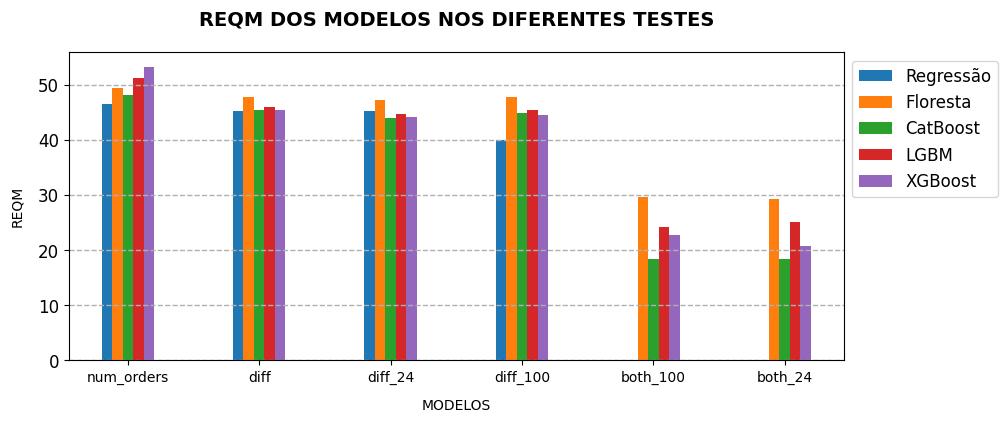

In [25]:
# Plotando um gráfico de barras para visualização dos reqm dos modelos
ax = df_reqm.plot(kind='bar',
                    figsize=[10, 4],
                    width=0.4)

# Ajustando o título e os rótulos dos eixos
ax.set_title('REQM DOS MODELOS NOS DIFERENTES TESTES', fontsize=14, weight='bold', pad=20)
ax.set_xlabel('MODELOS', fontsize=10, labelpad=10)
ax.set_ylabel('REQM', fontsize=10, labelpad=10)

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(df_reqm.index, rotation=0)

# Ajustando o tamanho dos rótulos dos eixos
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Adicionando gridlines
ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')

# Posicionando a legenda fora do gráfico
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Exibindo o gráfico
plt.show()

**CONCLUSÕES:**

* **num_orders:** O teste utilizando apenas a coluna com dados originais foi o que apresentou pior resultado de REQM;  
  
  
* **diff:** O teste utilizando a coluna com dados das diferenças de séries temporais já apresentaram um resultado um pouco superior ao teste somente com os dados originais, mais ainda com um REQM muito elevado;   


* **diff_24:** O teste utilizando a coluna 'diff' com todas as características criadas e considerando 24h de média móvel e defasagem, apresentou uma pequena melhor nos resultados dos modelos CatBoost, LGBM e XGBoost, mas não foi uma alteração muito significativa;  


* **diff_100:** O teste utilizando a coluna 'diff' com todas as características criadas e considerando 100h de média móvel e defasagem, apresentou melhora apenas no modelo de Regressão Linear, sendo que os demais mantiveram o desempenho ou até mesmo pioraram um pouco seu resultado;


* **both_100:** O teste utilizando tanto a coluna 'diff' quanto a coluna 'num_orders' com os dados originais, além das colunas com todas as características criadas e considerando 100h de média móvel e defasagem, apresentou uma significativa melhora de REQM em todos os modelos, com exceção do modelo de Regressão Linear, que apresentou algum problema e retornou resultados extremamente baixos de REQM, indicando possível overfitting ou que a combinação de dados originais e diferenças de séries temporais pode ter impactado o modelo.


* **both_24:** O teste utilizando tanto a coluna 'diff' quanto a coluna 'num_orders' com os dados originais, além das colunas com todas as características criadas e considerando 24h de média móvel e defasagem, manteve praticamente os mesmos resultados de REQM dos testes com todas as colunas considerando 100h, sendo muito bons resultados (com excessão da Regressão Logística que teve resultados desconsiderados pelos motivos já explicados acima)


**Resumo:**
Dentre todos os testes realizados, os melhores resultados obtidos foram com o DataFrame constando simultaneamente das colunas de números de pedidos (dados originais) 'num_orders' e da coluna 'diff' com as diferenças de séries temporais, além das colunas de características criadas, como dia da semana, dia, mês, média móvel e defasagem (lag).


### Análise dos Tempos para Treinamento dos Modelos

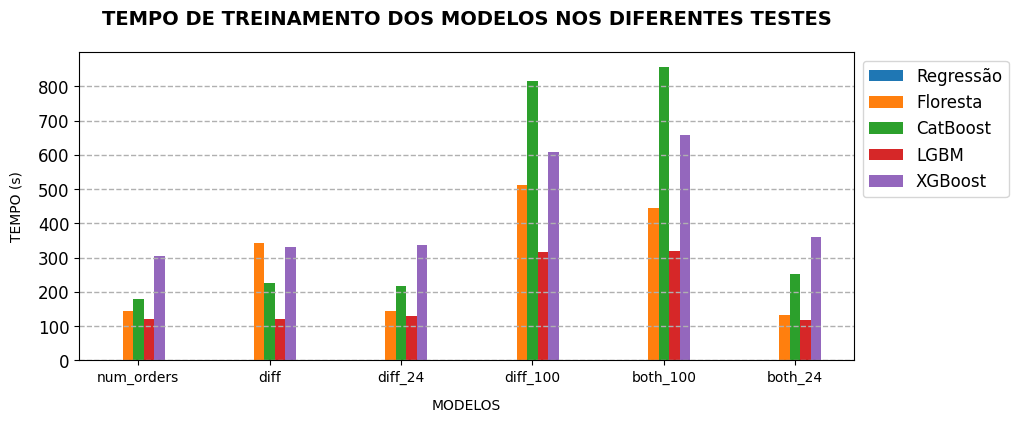

In [26]:
# Plotando um gráfico de barras para visualização dos tempos de treinamento dos modelos
ax = df_time_train.plot(kind='bar',
                    figsize=[10, 4],
                    width=0.4)

# Ajustando o título e os rótulos dos eixos
ax.set_title('TEMPO DE TREINAMENTO DOS MODELOS NOS DIFERENTES TESTES', fontsize=14, weight='bold', pad=20)
ax.set_xlabel('MODELOS', fontsize=10, labelpad=10)
ax.set_ylabel('TEMPO (s)', fontsize=10, labelpad=10)

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(df_time_train.index, rotation=0)

# Ajustando o tamanho dos rótulos dos eixos
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Adicionando gridlines
ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')

# Posicionando a legenda fora do gráfico
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Exibindo o gráfico
plt.show()

Em relação aos tempos de treinamento dos modelos, a Regressão Logística apresenta de longe o melhor desempenho, tendo todos os resultados abaixo de 1 segundo para o treinamento dos modelos, mesmo quando os dados estavam mais volumosos. Porém, como este modelo apresentou problemas com os resultados de REQM, ele será desconsiderado para a análise.


Como os resultados de REQM foram muito melhores para os testes com todas as colunas disponíveis (both_24 e both_100), vamos considerar apenas estes dois testes para definirmos o melhor resultado.

Comparando os tempos gastos para os treinamentos nos testes both_24 e both_100, podemos observar que os tempos foram muito menos quando consideramos 24h de defasagem e média móvel

### Conclusão Final

Dentre todos os testes realizados, o melhor modelo obtido foi o **CatBoost** para o teste **both_24** que contava com todas as colunas disponíveis simultaneamente e considerando 24h de defasagem e média móvel, pois ele obteve o menor resultado de REQM dentre os resultados válidos e obteve um tempo muito melhor em relação ao teste com 100h de defasagem e média móvel.


**MELHOR MODELO:** CatBoost do teste both_24